# Тестирование обобщающего NN-классификатора новообразований молочной железы

- [Матрицы ошибок](#Матрицы-ошибок)
- [Важность признаков](#Важность-признаков)

In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import definitions as defs
from utils import visualization as viz

In [2]:
generalizing_model = tf.keras.models.load_model(defs.GENERALIZING_MODEL)

entire_ds = defs.get_dataset_from_csv(defs.ENTIRE_DATA_PATH)
train_ds = defs.get_dataset_from_csv(defs.TRAIN_DATA_PATH)
val_ds = defs.get_dataset_from_csv(defs.VALIDATION_DATA_PATH)
test_ds = defs.get_dataset_from_csv(defs.TEST_DATA_PATH)

## Матрицы ошибок

Построим матрицы ошибок с ещё одной меткой "неопределён". Эта метку будем назначать в том случае, если ни для одной другой метки вероятность не превысила заданный порог. Порог будем менять.

In [3]:
def get_true_predicted_labels(threshold):
    true_labels = []
    predicted_labels = []
    for point, true_probabilities in test_ds:
        true_label_index = np.array(true_probabilities[0]).argmax()
        true_label = defs.LABELS[true_label_index]
        true_labels.append(true_label)

        predicted_probabilities = generalizing_model.predict(point)
        best_predicted_probability = np.array(predicted_probabilities[0]).max()
        if best_predicted_probability < threshold:
            predicted_label = 'неопределён'
        else:
            predicted_label_index = np.array(predicted_probabilities[0]).argmax()
            predicted_label = defs.LABELS[predicted_label_index]
        predicted_labels.append(predicted_label)

    return true_labels, predicted_labels

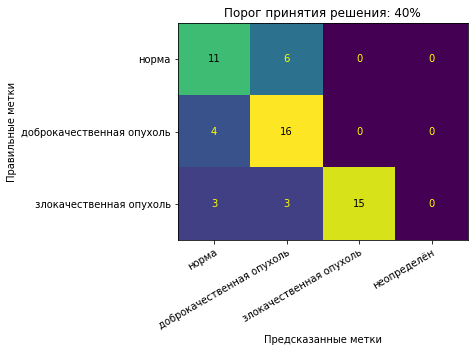

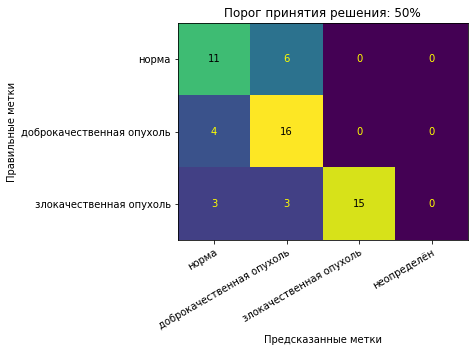

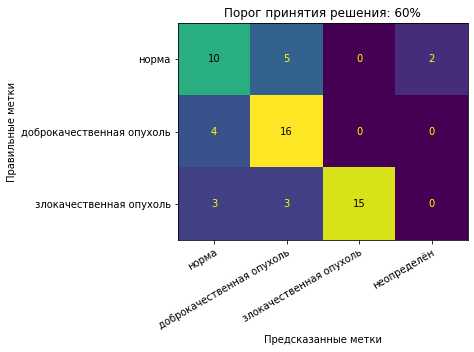

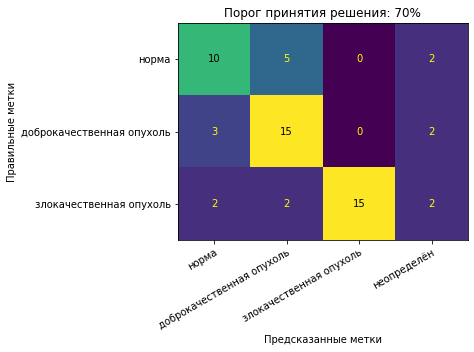

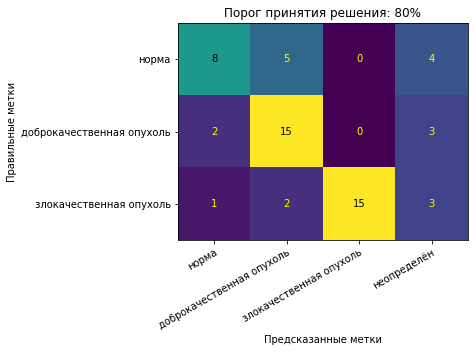

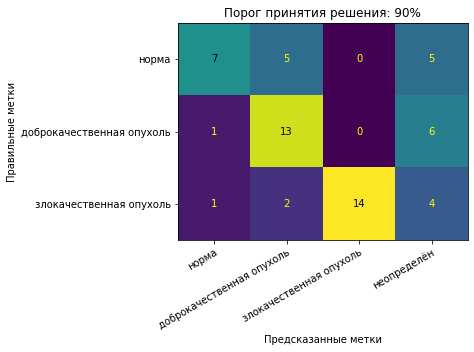

In [4]:
for threshold in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    ys_true, ys_pred = get_true_predicted_labels(threshold)
    cm = viz.get_confusion_matrix(ys_true, ys_pred, defs.LABELS, defs.LABELS + ['неопределён'])
    viz.plot_confusion_matrix(cm, defs.LABELS, defs.LABELS + ['неопределён'], threshold=threshold)

## Важность признаков

In [5]:
defs.INPUT_NAMES.pop('label')

In [6]:
test_ds_evaluation = generalizing_model.evaluate(test_ds, verbose=0)[1]
print(f'Точность с учётом всех признаков: {test_ds_evaluation:2.2%}')

Точность с учётом всех признаков: 72.41%


In [7]:
def test(n):
    """
    """
    i = 0
    for _ in itertools.combinations(range(36), n):
        i += 1
    print(f'Количество комбинаций длиной {n} из 36 = {i}.')
    
    def leave_features(features, dataset):
        """Зануляет все признаки, кроме заданных.
        
        :param features: признаки, которые не зануляются.
        :param dataset: заданный датасет.
        :return dataset: обработанный датасет.
        """
        def zero_feature(point, label):
            """Зануляет признак в точке данных.

            :param point: точка данных
            :param label: метка
            """
            if defs.INPUT_NAMES[feature_name] == 'numerical':
                point[feature_name] = tf.constant(
                    np.array(0., dtype=np.float32),
                    dtype=tf.float32,
                    shape=(1,)
                )
            else:
                point[feature_name] = tf.constant(
                    np.array(0, dtype=np.int32),
                    dtype=tf.int32,
                    shape=(1,)
                )
            return point, label
        
        for feature_name in defs.INPUT_NAMES.keys():
            if feature_name not in features:
                dataset = dataset.map(zero_feature)
        return dataset
    
    evaluations = []
    for feature_names in itertools.combinations(defs.INPUT_NAMES.keys(), n):
        test_ds_zeroed = leave_features(feature_names, test_ds)
        evaluation = generalizing_model.evaluate(test_ds_zeroed, verbose=0)[1]
        evaluations.append(evaluation * 100)
        
    plt.hist(evaluations, bins=100, range=(0, 100))
    plt.show()

Количество комбинаций длиной 1 из 36 = 36.


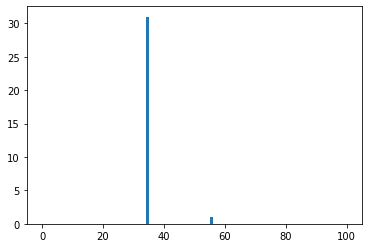

In [8]:
test(1)

Количество комбинаций длиной 2 из 36 = 630.


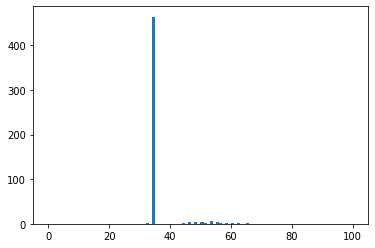

In [9]:
test(2)

Количество комбинаций длиной 3 из 36 = 7140.


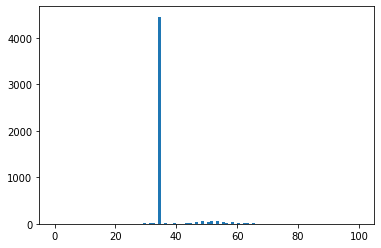

In [10]:
test(3)

Количество комбинаций длиной 4 из 36 = 58905.


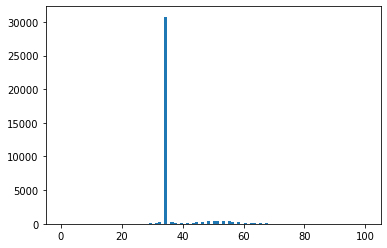

In [11]:
test(4)